In [1]:
### python imports & personal functions ###

%autosave 120
%matplotlib inline
from basicimports import *

# The directory for the 25CCO calculations
forme_loc = home+'cco25/'

Autosaving every 120 seconds
Last ran on /home/tboland1/Crozier Group Dropbox/Crozier Group/Crozier Group User- Tara Boland/pymatgen from 2019-02-11 16:58:35.917202. 

home is /home/tboland1/Dropbox/TaraB/DFT/


## Making 25% Ca doped CeO2 
Initially I have started with a 1x1x1 conventional unit cell of CeO$_{2}$.

This is done to ensure that the code produces results which align with what I believe the correct answer is.

This code should only get one crystallographically unique structure. 

In [3]:
# Define the Specie, Create the Structure, Use OrdDisTran generator
specie = [{"Ce4+":0.75,"Ca2+":0.25}, {"O2-":1}]
structure = Structure.from_spacegroup("Fm-3m", Lattice.cubic(5.494),
                                 specie, 
                                 [[0, 0, 0],[0.25,0.25,0.25]])
struct = structure.copy()

from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation
# generate all possible crystallographical configurations
trans = OrderDisorderedStructureTransformation()
ss = trans.apply_transformation(struct, return_ranked_list=10000)
print('There is a total of {} structures created using the ODT.'.format(len(ss)))

There is a total of 4 structures created using the ODT.


## Remove Duplicated Structures from our list
This generator method does not remove duplicate structures.

Pymatgen's structure matcher can be used to reduce the number of duplicated structures generated using the OrderDisorderedStructureTransformation.

In [4]:
# rm duplicate structs
from pymatgen.analysis.structure_matcher import StructureMatcher

# initialize the object
matcher = StructureMatcher()

# Pass a list of structures to the matcher
# so the SM can group the structures by their similarity
matches = matcher.group_structures([d["structure"] for d in ss])

groups = [matches[i][0] for i in range(len(matches))]
unique_count = len(groups)
num_freq =  [len(matches[i]) for i in range(len(matches))]
print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occures is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

The total number of unique structures found is 1.
The number frequency with which each structure occures is 
	 4.


### Repeat for  2x2x2 unit cell
* make the 2x2x2 supercell
* check the struct
* apply the odst

In [5]:
struct_222 = structure.copy()
struct_222.make_supercell([2,2,2])
gvl(struct_222)

In [6]:
ss = trans.apply_transformation(struct_222, return_ranked_list=100)
print(len(ss))

100


Vacancy creating code because I can't find resources to do pymatgen

This was the structure variable for the first for loop structure editing to obtain the correct formalism for one atom structure to be extended to multiple structures.
% teststr = groups[1][0]

Function: Iteration to ensure we are removing the oxygen atoms from within the (0,0,0) unit cell. The get_neighbor function returns a list of atom numbers from nearby unit cells.

Augmentations to the structure: Delete the atom from the structure corresponding to each dopant. The loop then breaks from the current dopant in the structure and moves to the next dopant site to look at where to remove an oxygen atom from next.

Set the break and counter flag for the iterations. Run over each atom finding the  from the list

### Get Unique structures 
This should return more unique structures for the 2x2x2 supercell since there are more possible combinations of unique Ca arrangements. 

In [7]:
# pass list of structs to SM
matches = matcher.group_structures([d["structure"] for d in ss])

# get the first structure out of each unique structure listed
groups = [matches[i][0] for i in range(len(matches))]

unique_count = len(groups)
num_freq =  [len(matches[i]) for i in range(len(matches))]

print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occures is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

for i in range(len(groups)):
    gvl(groups[i])

The total number of unique structures found is 3.
The number frequency with which each structure occures is 
	 12 4 84.


### Write out the doped structure and induce vacancies

Create the structure files in poscar format and remove the extra O atom to enforce charge neutrality. 

In [8]:
# creating structures, dft inputs, 
print("Getting the location of the dopant atoms")
## Now find all Ca2+ and get the NN and remove 1 Oxygen atom from the NN shell
file_counter = 0
struct_doped = []
for temp_struc in groups:
    # 1. get the dopant atoms from each unique structure in the array
    nn = []
    for atom in temp_struc:
        # get the element symbol from the structure
        atom_tag = str(atom.specie.element)
        if atom_tag == "Ca":
            #print(atom.coords)
            nn_list = temp_struc.get_neighbors(
                site=atom, r=2.4, include_image=True, include_index=True)
            nn.append(nn_list)
    #print(nn)
    # get a copy to change the structure of
    del_struc = temp_struc.copy()
    print("\nThe starting composition is: ", del_struc.composition)
    # define flags & counters
    b_flag, counter = 0, 0
    remove_atoms = []

    # pull out the dopant atoms from the list and check the vacancy
    # locations are within the [0,0,0] unit cell for each structure at each dopant
    for dopant_atom in nn:
        # break flag reset to move onto next dopant
        if b_flag == 1:
            #print("Flag tripped moving to the next dopant atom to remove O")
            b_flag = 0
        #print(dopant_atom)
        for index in range(len(dopant_atom)):
            vacancy_site = dopant_atom[index]
            location = vacancy_site[len(vacancy_site) - 1]
            # make sure that the oxygen atom is in the [0,0,0] unit cell
            if str(location) == '[0 0 0]':
                if del_struc[vacancy_site[2]] != vacancy_site[0]:
                    print(
                        "Warning vacancy site being removed is not equal to the defect location in the [0,0,0] unit cell"
                    )
                print(dopant_atom[index])
                remove_atoms.append(vacancy_site[2])
                b_flag = 1
                counter += 1
                break
    for remove in sorted(remove_atoms, reverse=True):
        del del_struc[remove]

    print("There are {} dopant atoms in the structure."
          "\nThe defect composition is {}"
          "\nThe charge is {}".format(counter, del_struc.composition,
                                      del_struc.charge))
    struct_doped.append(del_struc)
    gvl(del_struc)
    filename = "POSCAR_" + str(file_counter) + str(del_struc.composition)
    file_counter += 1
    del_struc.to(filename=filename, fmt="POSCAR")

Getting the location of the dopant atoms

The starting composition is:  Ca2+8 Ce4+24 O2-64
(PeriodicSite: O2- (1.3735, 1.3735, 6.8675) [0.1250, 0.1250, 0.6250], 2.378971784195853, 33, array([0, 0, 0]))
(PeriodicSite: O2- (1.3735, 6.8675, 6.8675) [0.1250, 0.6250, 0.6250], 2.378971784195853, 35, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 1.3735, 6.8675) [0.6250, 0.1250, 0.6250], 2.378971784195853, 37, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 6.8675, 6.8675) [0.6250, 0.6250, 0.6250], 2.378971784195853, 39, array([0, 0, 0]))
(PeriodicSite: O2- (1.3735, 1.3735, 1.3735) [0.1250, 0.1250, 0.1250], 2.378971784195853, 32, array([0, 0, 0]))
(PeriodicSite: O2- (1.3735, 6.8675, 1.3735) [0.1250, 0.6250, 0.1250], 2.378971784195853, 34, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 1.3735, 1.3735) [0.6250, 0.1250, 0.1250], 2.378971784195853, 36, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 6.8675, 1.3735) [0.6250, 0.6250, 0.1250], 2.378971784195853, 38, array([0, 0, 0]))
There are 8 dopant at


The starting composition is:  Ca2+8 Ce4+24 O2-64
(PeriodicSite: O2- (1.3735, 1.3735, 1.3735) [0.1250, 0.1250, 0.1250], 2.378971784195853, 32, array([0, 0, 0]))
(PeriodicSite: O2- (1.3735, 1.3735, 6.8675) [0.1250, 0.1250, 0.6250], 2.378971784195853, 33, array([0, 0, 0]))
(PeriodicSite: O2- (1.3735, 6.8675, 1.3735) [0.1250, 0.6250, 0.1250], 2.378971784195853, 34, array([0, 0, 0]))
(PeriodicSite: O2- (1.3735, 6.8675, 6.8675) [0.1250, 0.6250, 0.6250], 2.378971784195853, 35, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 1.3735, 1.3735) [0.6250, 0.1250, 0.1250], 2.378971784195853, 36, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 1.3735, 6.8675) [0.6250, 0.1250, 0.6250], 2.378971784195853, 37, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 6.8675, 1.3735) [0.6250, 0.6250, 0.1250], 2.378971784195853, 38, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 6.8675, 6.8675) [0.6250, 0.6250, 0.6250], 2.378971784195853, 39, array([0, 0, 0]))
There are 8 dopant atoms in the structure.
The defect composit


The starting composition is:  Ca2+8 Ce4+24 O2-64
(PeriodicSite: O2- (1.3735, 1.3735, 6.8675) [0.1250, 0.1250, 0.6250], 2.378971784195853, 33, array([0, 0, 0]))
(PeriodicSite: O2- (1.3735, 6.8675, 6.8675) [0.1250, 0.6250, 0.6250], 2.378971784195853, 35, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 6.8675, 6.8675) [0.6250, 0.6250, 0.6250], 2.378971784195853, 39, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 1.3735, 6.8675) [0.6250, 0.1250, 0.6250], 2.378971784195853, 37, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 1.3735, 1.3735) [0.6250, 0.1250, 0.1250], 2.378971784195853, 36, array([0, 0, 0]))
(PeriodicSite: O2- (1.3735, 1.3735, 1.3735) [0.1250, 0.1250, 0.1250], 2.378971784195853, 32, array([0, 0, 0]))
(PeriodicSite: O2- (1.3735, 6.8675, 1.3735) [0.1250, 0.6250, 0.1250], 2.378971784195853, 34, array([0, 0, 0]))
(PeriodicSite: O2- (6.8675, 6.8675, 1.3735) [0.6250, 0.6250, 0.1250], 2.378971784195853, 38, array([0, 0, 0]))
There are 8 dopant atoms in the structure.
The defect composit

In [9]:
# show structs
show_struct_ase(Poscar.from_file("POSCAR_0Ca2+8 Ce4+24 O2-56").structure)

show_struct_ase(Poscar.from_file("POSCAR_1Ca2+8 Ce4+24 O2-56").structure)

show_struct_ase(Poscar.from_file("POSCAR_2Ca2+8 Ce4+24 O2-56").structure)

# Relaxed Analysis needed

Of the three structures cfig3 had the lowest energy. Cfig1 is running NEB currently.
* The initial state is the original relaxed configuration
* One atom is moved to create the final state for 2 structures
    * The highest energy state and the lowest energy state 
    * This will compare the energy of the two final states to discern if the set up for the vacancies played a significant role in the system's total energy. 
* Need to create code which looks at the NN  and NNN to intelligently pick the vacancy site. Or look into the vacancy generator in pymatgen. * Run & create NEB for cfig3

**CFIG1**

Import the poscar's to perform NEB. Translate the 70th atom to the nearby vacancy site. Site was picked using VESTA. The atom number to reference from VESTA to pymatgen is Atom: #-1. 

poscar_nebCfig1_initial is the first structure create above relaxed in vasp.
poscar_nebCfig1_final is *not* relaxed and is the final structure for the NEB calculation. It is currently relaxing

In [18]:
# translate sites
# path_1 = os.path.dirname(path='ca25/POSCAR_cfig3-relaxed')
path_1="POSCAR_cfig3-relaxed"
poscar_nebCfig1_intial = Poscar.from_file(filename=path_1).structure
poscar_nebCfig1_final = poscar_nebCfig1_intial.copy()
poscar_nebCfig1_final.translate_sites(
    indices=69, vector=[0, 0, -2.72269],
    frac_coords=False, to_unit_cell=True)
show_struct_ase(poscar_nebCfig1_final)
poscar_nebCfig1_final.to(fmt="POSCAR", 
                         filename="POSCAR-cfig1-neb-final")

Poscar_cfig1-neb-final is relaxed.The location of the file is currently on the cluster. 

**CFIG3**

Repeat steps above used for cfig1 with cfig3.
OXYGEN ATOM 36 is moved in the -x direction.

In [ ]:
# translate sites
path_1 = os.path.abspath(path=pymatgen_loc + 'ca25/POSCAR_cfig3-relaxed')
poscar_nebCfig1_initial = Poscar.from_file(filename=path_1).structure
poscar_nebCfig1_final = poscar_nebCfig1_initial.copy()
show_struct_ase(poscar_nebCfig1_initial)
poscar_nebCfig1_final.translate_sites(
    indices=36, vector=[-2.72269, 0, 0], frac_coords=False, to_unit_cell=True)
show_struct_ase(poscar_nebCfig1_final)
poscar_nebCfig1_final.to(fmt="POSCAR", filename="ca25/POSCAR-cfig1-neb-final")

Then interpolate between the final and initial structure to get the images to do an NEB calculation.

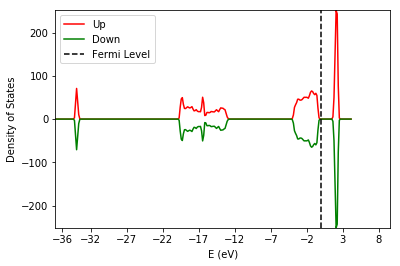

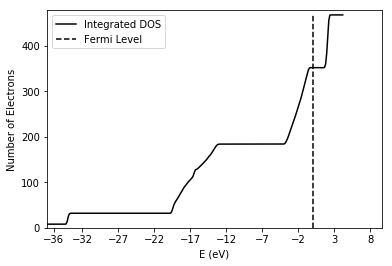

In [15]:
plot_density_of_states('/home/tboland1/Dropbox/TaraB/DFT/CaDopedBulk/relax-25CaCfigs/cfig3/nfa0-sv/')